Access-Control Queuing Task
---
This is a decision task involving access control to a set of 10 servers. Customers of four different priorities arrive at a single queue. If given access to a server, the customers pay a reward of `1, 2, 4, or 8` to the server, depending on their priority, with higher priority customers paying more. In each time step, the customer at the head of the queue is either accepted (assigned to one of the servers) or rejected (removed from the queue, with a reward of zero). In either case, on the next time step the next customer in the queue is considered. The queue never empties, and the priorities of the customers in the queue are equally randomly distributed. Of course a customer cannot be served if there is no free server; the customer is always rejected in this case. Each busy server becomes free with probability `p = 0.06` on each time step.

The task is to decide on each step whether to accept or reject the next customer, on the basis of his priority and the number of free servers, so as `to maximize long-term reward without discounting`.

- State(num_servers, priority)
- Action(1, 0)
- Reward(1, 2, 4, 8)
---
<img src="differential_sarsa.png" width="600" style="float:left">

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from TileCoding import *

In [6]:
ACTIONS = [0, 1]

In [60]:
class ValueFunction:

    def __init__(self, alpha=0.01, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.alpha = alpha / numOfTilings  # learning rate for each tile

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.serverScale = self.numOfTilings / 10.0  # 10 servers
        self.priorityScale = self.numOfTilings / 3.0  # 4 kinds of priorities

    # get indices of active tiles for given state and action
    def getActiveTiles(self, n_server, priority, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.serverScale * n_server, self.priorityScale * priority],
                            [action])
#         print("active tiles for {}-{}-{}: {}".format(n_server, priority, action, activeTiles))
        return activeTiles

    # estimate the value of given state and action
    def value(self, state, action):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def update(self, state, action, delta):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        
        delta *= self.alpha
        for activeTile in activeTiles:
            self.weights[activeTile] += delta
            
    def stateValue(self, state):
        if state[0] == 0:
            # no server available
            return self.value(state, 0)
        values = [self.value(state, a) for a in ACTIONS]
        return max(values)

In [58]:
class ServerAcess:
    def __init__(self, exp_rate=0.3, lr=0.1, beta=0.01):
        self.n_server = 10
        self.free_prob = 0.06
        self.priorities = range(4)
        self.actions = ACTIONS  # 0: reject; 1: accept
        self.state = (0, 0)  # (num_servers, priority)
        
        self.exp_rate = exp_rate
        self.lr = lr
        self.beta = beta
#         self.alpha = alpha
        
    def numFreeServers(self):
        n = 0
        n_free_server = self.state[0]
        n_busy_server = self.n_server - n_free_server
        for _ in range(n_busy_server):
            if np.random.uniform(0, 1) <= 0.06:
                n += 1
        n_free_server += n
        self.state = (n_free_server, self.state[1])
        return n_free_server
    
    def chooseAction(self, valueFunc):
        n_free_server = self.numFreeServers()
        if n_free_server == 0:
            return 0
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            values = {}
            for a in self.actions:
                v = valueFunc.value(self.state, a)
                values[a] = v
            action = np.random.choice([k for k, v in values.items() if v == max(values.values())])
        return action
    
    def nxtState(self, action):
        if action == 1:
            n_free_server = self.state[0] - 1
        else:
            n_free_server = self.state[0]
        priority = np.random.choice(self.priorities)
        self.state = (n_free_server, priority)
        return self.state
    
    def giveReward(self, action):
        # recieve a reward by taking the action
        if action == 1:
            priority = self.state[1]
            return np.power(2, priority)
        return 0
    
    def run(self, valueFunc, steps=1000, inner_steps=100, debug=False):
        # updating average reward estimation along the way
        avg_reward = 0
        self.state = (10, np.random.choice(self.priorities))
        cur_state = self.state
        cur_action = self.chooseAction(valueFunc)  # n free server is also updated
        
        total_reward = 0
        for i in range(1, steps+1):
            reward = self.giveReward(cur_action)
            new_state = self.nxtState(cur_action)
            new_action = self.chooseAction(valueFunc)
            
            total_reward += reward
            if debug:
                print("state {} action {} reward {}".format(cur_state, cur_action, reward))
            if i % inner_steps == 0:
                print("step {} -> avg reward {} total reward {}".format(i, avg_reward, total_reward))
                total_reward = 0
            
            delta = reward - avg_reward + valueFunc.value(new_state, new_action) - valueFunc.value(cur_state, cur_action)
            avg_reward += self.beta*delta
            valueFunc.update(cur_state, cur_action, delta)
            
            cur_state = new_state
            cur_action = new_action

In [59]:
sa = ServerAcess(exp_rate=0.1)
vf = ValueFunction()
sa.run(vf, steps=50000, inner_steps=5000, debug=False)

step 5000 -> avg reward 2.5898638607383124 total reward 11564
step 10000 -> avg reward 1.9977852171103436 total reward 11136
step 15000 -> avg reward 2.0811726628648675 total reward 11844
step 20000 -> avg reward 2.7027010976915133 total reward 11292
step 25000 -> avg reward 1.9270934931878343 total reward 11388
step 30000 -> avg reward 2.4730018256264508 total reward 11507
step 35000 -> avg reward 2.4343651511460105 total reward 11734
step 40000 -> avg reward 2.082349301008451 total reward 10928
step 45000 -> avg reward 1.9432234467044867 total reward 10750
step 50000 -> avg reward 2.462456921306841 total reward 11731


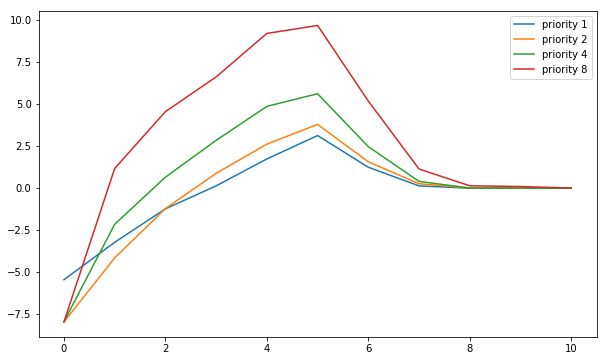

In [46]:
plt.figure(figsize=[10, 6])

for prioriy in range(4):
    n_servers = []
    values = []
    for n_server in range(11):
        value = vf.stateValue((n_server, prioriy))
        n_servers.append(n_server)
        values.append(value)
    plt.plot(n_servers, values, label="priority {}".format(np.power(2, prioriy)))
plt.legend()

In [61]:
import numpy as np


def create_tiling(feat_range, bins, offset):
    """
    Create 1 tiling spec of 1 dimension(feature)
    feat_range: feature range; example: [-1, 1]
    bins: number of bins for that feature; example: 10
    offset: offset for that feature; example: 0.2
    """
    
    return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset


def create_tilings(feature_ranges, number_tilings, bins, offsets):
    """
    feature_ranges: range of each feature; example: x: [-1, 1], y: [2, 5] -> [[-1, 1], [2, 5]]
    number_tilings: number of tilings; example: 3 tilings
    bins: bin size for each tiling and dimension; example: [[10, 10], [10, 10], [10, 10]]: 3 tilings * [x_bin, y_bin]
    offsets: offset for each tiling and dimension; example: [[0, 0], [0.2, 1], [0.4, 1.5]]: 3 tilings * [x_offset, y_offset]
    """
    tilings = []
    # for each tiling
    for tile_i in range(number_tilings):
        tiling_bin = bins[tile_i]
        tiling_offset = offsets[tile_i]
        
        tiling = []
        # for each feature dimension
        for feat_i in range(len(feature_ranges)):
            feat_range = feature_ranges[feat_i]
            # tiling for 1 feature
            feat_tiling = create_tiling(feat_range, tiling_bin[feat_i], tiling_offset[feat_i])
            tiling.append(feat_tiling)
        tilings.append(tiling)
    return np.array(tilings)


def get_tile_coding(feature, tilings):
    """
    feature: sample feature with multiple dimensions that need to be encoded; example: [0.1, 2.5], [-0.3, 2.0]
    tilings: tilings with a few layers
    return: the encoding for the feature on each layer
    """
    num_dims = len(feature)
    feat_codings = []
    for tiling in tilings:
        feat_coding = []
        for i in range(num_dims):
            feat_i = feature[i]
            tiling_i = tiling[i]  # tiling on that dimension
            coding_i = np.digitize(feat_i, tiling_i)
            feat_coding.append(coding_i)
        feat_codings.append(feat_coding)
    return np.array(feat_codings)

In [62]:
server_range = [0, 10]
priority_range = [0, 3]
feature_ranges = [server_range, priority_range]  # 2 features
number_tilings = 8
bins = [[16, 16] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(server_range[0], server_range[1], number_tilings), 
                                  np.linspace(priority_range[0], priority_range[1], number_tilings))]

tilings = create_tilings(feature_ranges=feature_ranges, number_tilings=number_tilings, bins=bins, offsets=offsets)

In [75]:
tilings.shape

(8, 2, 15)

In [80]:
# example Q-function

class QValueFunction:

    def __init__(self, tilings, actions, lr):
        self.tilings = tilings
        self.num_tilings = len(self.tilings)
        self.actions = [0, 1]
        self.lr = lr # / self.num_tilings  # learning rate equally assigned to each tiling
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling) for tiling in
                            self.tilings]  # [(10, 10), (10, 10), (10, 10)]
        self.q_tables = [np.zeros(shape=(state_size + (len(self.actions),))) for state_size in self.state_sizes]

    def value(self, state, action):
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)

        value = 0
        for coding, q_table in zip(state_codings, self.q_tables):
            # for each q table
            value += q_table[tuple(coding) + (action_idx,)]
        return value / self.num_tilings

    def update(self, state, action, delta):
        n_server, priority = state
        state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
        action_idx = self.actions.index(action)
        
        delta *= self.lr
        for coding, q_table in zip(state_codings, self.q_tables):
            q_table[tuple(coding) + (action_idx,)] += delta
    
#     def update(self, state, action, target):
#         n_server, priority = state
#         state_codings = get_tile_coding(state, self.tilings)  # [[5, 1], [4, 0], [3, 0]] ...
#         action_idx = self.actions.index(action)
        
#         for coding, q_table in zip(state_codings, self.q_tables):
#             delta = target - q_table[tuple(coding) + (action_idx,)]
#             q_table[tuple(coding) + (action_idx,)] += self.lr*delta
    
    def stateValue(self, state):
        if state[0] == 0:
            # no server available
            return self.value(state, 0)
        values = [self.value(state, a) for a in ACTIONS]
        return max(values)

In [81]:
class ServerAcess:
    def __init__(self, exp_rate=0.3, lr=0.1, beta=0.01):
        self.n_server = 10
        self.free_prob = 0.06
        self.priorities = range(4)
        self.actions = ACTIONS  # 0: reject; 1: accept
        self.state = (0, 0)  # (num_servers, priority)
        
        self.exp_rate = exp_rate
        self.lr = lr
        self.beta = beta
#         self.alpha = alpha
        
    def numFreeServers(self):
        n = 0
        n_free_server = self.state[0]
        n_busy_server = self.n_server - n_free_server
        for _ in range(n_busy_server):
            if np.random.uniform(0, 1) <= 0.06:
                n += 1
        n_free_server += n
        self.state = (n_free_server, self.state[1])
        return n_free_server
    
    def chooseAction(self, valueFunc):
        n_free_server = self.numFreeServers()
        if n_free_server == 0:
            return 0
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            values = {}
            for a in self.actions:
                v = valueFunc.value(self.state, a)
                values[a] = v
            action = np.random.choice([k for k, v in values.items() if v == max(values.values())])
        return action
    
    def nxtState(self, action):
        if action == 1:
            n_free_server = self.state[0] - 1
        else:
            n_free_server = self.state[0]
        priority = np.random.choice(self.priorities)
        self.state = (n_free_server, priority)
        return self.state
    
    def giveReward(self, action):
        # recieve a reward by taking the action
        if action == 1:
            priority = self.state[1]
            return np.power(2, priority)
        return 0
    
    def run(self, valueFunc, steps=1000, inner_steps=100, debug=False):
        # updating average reward estimation along the way
        avg_reward = 0
        self.state = (10, np.random.choice(self.priorities))
        cur_state = self.state
        cur_action = self.chooseAction(valueFunc)  # n free server is also updated
        
        total_reward = 0
        for i in range(1, steps+1):
            reward = self.giveReward(cur_action)
            new_state = self.nxtState(cur_action)
            new_action = self.chooseAction(valueFunc)
            
            total_reward += reward
            if debug:
                print("state {} action {} reward {}".format(cur_state, cur_action, reward))
            if i % inner_steps == 0:
                print("step {} -> avg reward {} total reward {}".format(i, avg_reward, total_reward))
                total_reward = 0
            
            target = reward - avg_reward + valueFunc.value(new_state, new_action)
            delta = reward - avg_reward + valueFunc.value(new_state, new_action) - valueFunc.value(cur_state, cur_action)
            avg_reward += self.beta*delta
            valueFunc.update(cur_state, cur_action, delta)
            
            cur_state = new_state
            cur_action = new_action

In [84]:
sa = ServerAcess(exp_rate=0.1)
vf = QValueFunction(tilings=tilings, actions=[0, 1], lr=0.01)
sa.run(vf, steps=100000, inner_steps=5000, debug=False)

step 5000 -> avg reward 2.1019611666225098 total reward 10666
step 10000 -> avg reward 2.383694303802434 total reward 10957
step 15000 -> avg reward 2.02584251326506 total reward 10867
step 20000 -> avg reward 2.163536587536679 total reward 10653
step 25000 -> avg reward 2.489066319454473 total reward 11112
step 30000 -> avg reward 2.0464605655433745 total reward 10949
step 35000 -> avg reward 2.1653024589223544 total reward 10840
step 40000 -> avg reward 2.1597426022410304 total reward 11095
step 45000 -> avg reward 1.8629362023037483 total reward 10798
step 50000 -> avg reward 2.229973080461522 total reward 10755
step 55000 -> avg reward 2.134778970204409 total reward 10777
step 60000 -> avg reward 2.255413028642548 total reward 10557
step 65000 -> avg reward 1.785408910292558 total reward 10642
step 70000 -> avg reward 2.2913496596071528 total reward 10580
step 75000 -> avg reward 2.358822343640672 total reward 10852
step 80000 -> avg reward 2.0711822310522807 total reward 10648
ste

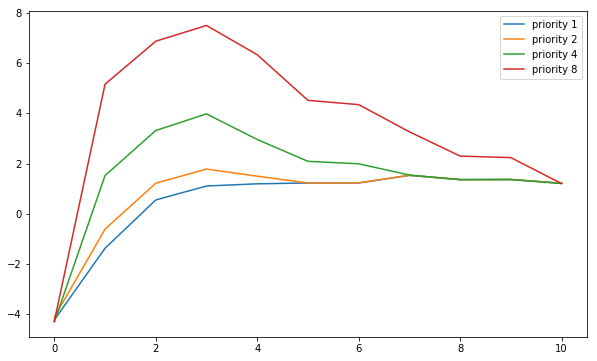

In [85]:
plt.figure(figsize=[10, 6])

for prioriy in range(4):
    n_servers = []
    values = []
    for n_server in range(11):
        value = vf.stateValue((n_server, prioriy))
        n_servers.append(n_server)
        values.append(value)
    plt.plot(n_servers, values, label="priority {}".format(np.power(2, prioriy)))
plt.legend()